In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pickle
from sklearn.utils.class_weight import compute_class_weight
import statistics

In [2]:
device = torch.device('cuda')

In [3]:
rng = np.random.default_rng(73512)

In [4]:
with open(r'train.pkl', 'rb') as f:
    data = pickle.load(f)

with open(r'test.pkl', 'rb') as f:
    verify_data = pickle.load(f)

In [8]:
for i in range(5):
    print(data[i])

(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0)
(array([ -1.,  -1., 144., ...,  32.,  -1.,  -1.]), 0)
(array([ 66., 100., 148., 148., 146.,  64., 146., 148.,  82.,   0.,  82.,
       100.,  34., 132., 180.,  65.,  80.,  81., 131.,  52.,  34.,  52.,
        64.,  52.,   3.,  66., 147.,  20.,   4., 132., 132., 100., 111.,
        74., 110.,  60.,  92.,  65., 100., 189.,  44.,   8.,   5.,  76.,
        31., 159.,   5., 124.,   4.,  12.,  51., 157.,  57.,  31., 183.,
        57.,  65.,  92.,  69., 124., 122.,  79., 110.,  76.,  12.,  12.,
        12.,  12.,   8., 159.,  12., 156., 100., 111.,  52., 121.,  36.,
        47.,  41.,  41.,   8., 172.,  38.,  12.,  78.,  12.,  88.,  47.,
       119.,  20.,  47.,  12., 159.,  20.,  20.,  76.,  60., 110., 132.,
       185., 120.,  45., 110., 110.,  72., 124., 178.,  73.,   8.,  78.,
        12.,  42., 173.,  12., 150.,  84.,  66., 152.,  69.,   8.,  41.,
       159.,   5.,  78.,  44., 180.,  71.,  92., 152.,   6.,  12.,  45.,
        92., 12

# Data preprocessing

In [5]:
from sklearn.preprocessing import OneHotEncoder

categories = [row[1] for row in data]

#giving weights to each class based on how many labels it has for more balanced training of neural network
class_weights = torch.tensor(compute_class_weight('balanced', classes=np.array([0,1,2,3,4]), y=categories)).to(device) 

encoder = OneHotEncoder()
categories_2d = [[category] for category in categories]
onehot_encoded = encoder.fit_transform(categories_2d)
onehot_encoded_array = onehot_encoded.toarray()

data_modified = []
targets_modified = []
for i in range(len(data)):
    row = list(data[i][0])
    data_modified.append(row)
    row2 = onehot_encoded_array[i]
    targets_modified.append(row2)
data = [torch.tensor(row).to(torch.float32) for row in data_modified]
targets = [torch.tensor(row).to(torch.float32) for row in targets_modified]

In [6]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [7]:
data = np.array(data,dtype="object")
targets = np.array(targets,dtype="object")
train_indices = rng.random(len(data)) > 0.3
test_indices = ~train_indices
train_indices = np.where(train_indices==True)[0]
test_indices = np.where(test_indices==True)[0]
train_set = VariableLenDataset(data[train_indices], targets[train_indices])
test_set = VariableLenDataset(data[test_indices], targets[test_indices])

C:\Users\-\AppData\Local\Temp\ipykernel_16084\939005982.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array(data,dtype="object")
C:\Users\-\AppData\Local\Temp\ipykernel_16084\939005982.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign t

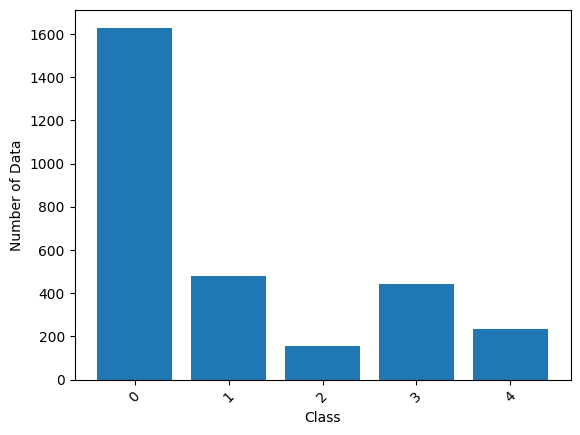

In [8]:
#histogram to see classes distribution
import numpy as np
import matplotlib.pyplot as plt

targets_flat = [np.argmax(target) for target in targets]
targets_flat = [int(target.item()) for target in targets_flat]

class_labels = np.arange(5)
train_class_counts = {label: targets_flat.count(label) for label in class_labels}

plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Data')
plt.xticks(rotation=45)
plt.show()


In [9]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

#since sequences have different lengths, there's need for 'padding' to make them equal length
def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

# LSTM model

In [10]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1]
        x = self.fc(out)
        return x, hidden

# Parameters

In [11]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False, collate_fn=pad_collate)
model = LSTMRegressor(1, 200, 4, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fun = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

# Training and evaluation

In [ ]:
#training
for epoch in range(251):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        
        preds, _ = model(x, (hidden, state))        
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 1.09
Epoch: 10, loss: 0.581
Epoch: 20, loss: 1.61
Epoch: 30, loss: 1.35


In [ ]:
#evaluation
with torch.no_grad():
    true_preds = 0
    num_preds = 0
    true_classes_preds = np.array([0,0,0,0,0])
    num_classes_preds = np.array([0,0,0,0,0])
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, _ = model(x, (hidden, state))
        preds = preds.squeeze(1)
        preds = (torch.round(preds).int()).long()
        if (torch.argmax(preds) == torch.argmax(targets)):
            true_preds +=1
            true_classes_preds[torch.argmax( 
                targets).item()]+=1
        num_classes_preds[torch.argmax(targets).item()]+=1
        num_preds += targets.shape[0]
acc = true_preds/num_preds
classes_acc = true_classes_preds/num_classes_preds

#Various indicators of model effectiveness or lack of it. Number of labels in classes is unbalanced, so accuracy can be misleading.
print("Number of classes predictions:",true_classes_preds)
print("Number of classes labels",num_classes_preds)
print("Classes accuracy:",classes_acc)
print("Mean:",statistics.mean(classes_acc))
print("Euclidean norm:",np.linalg.norm(np.array(classes_acc))/5)
print("Accuracy:",acc)


# Classify data with no labels

In [ ]:
#Data preprocessing - won't work if it has labels
from sklearn.preprocessing import OneHotEncoder

verify_categories = [row[1] for row in verify_data]


verify_data_modified = []
for i in range(len(verify_data)):
    row = list(verify_data[i])
    verify_data_modified.append(row)
verify_data = [torch.tensor(row).to(torch.float32) for row in verify_data_modified]

In [ ]:
from torch.utils.data import Dataset

class VerifyVariableLenDataset(Dataset):
    def __init__(self, in_data):
        self.data = in_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data = self.data[idx]
        return in_data

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def verify_pad_collate(batch, pad_value=0):
    xx = batch
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    
    return xx_pad, x_lens

In [ ]:
verify_data = np.array(verify_data,dtype="object")
verify_set = VerifyVariableLenDataset(verify_data)
verify_loader = DataLoader(verify_set, batch_size=1, shuffle=False, collate_fn=verify_pad_collate)

In [ ]:
#Data classification
import csv
predictions = []
with torch.no_grad():
    num_classes_preds = np.array([0,0,0,0,0])
    for x, x_len in verify_loader:
        x = x.to(device).unsqueeze(2)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, _ = model(x, (hidden, state))
        preds = preds.squeeze(1)
        preds = (torch.round(preds).int()).long()
        preds = torch.argmax(preds).item()
        num_classes_preds[preds]+=1
        predictions.append(preds)
    print("Classes predictions: ",num_classes_preds)

In [ ]:
#Save verified data to csv format
with open("predictions.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(predictions)